Camembert pour les designations

- On entraine QUE sur les lignes qui ont des desc
- On sauve le modele
- On Evalue le modele
- On recharge le modele, génère les embeddings et les sauve dans un CSV

In [1]:
from RktnChallenge.RktnModel import ModelTrainer



import tensorflow as tf


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import CamembertTokenizer, TFCamembertForSequenceClassification
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import AdamW

import ast

trainer = ModelTrainer("data_tr_lemm.csv","")
nb_epochs = 10
num_categories = 27
max_features = 250
checkpoint_path = "cbert_best_desi"

def convert_and_join(str_list):
    try:
        # Convertir la chaîne en liste
        real_list = ast.literal_eval(str_list)
        # Joindre la liste pour former une chaîne
        return " ".join(real_list)
    except (ValueError, SyntaxError):
        return ""



labels = y = trainer.encodeLabel("prdtypecode")
sentences =  trainer.data["designation_tkn"].apply(convert_and_join).values.tolist()


sentences_train, sentences_test, labels_train, labels_test = train_test_split(sentences, labels, test_size=0.2, random_state=42)
sentences_train, sentences_val, labels_train, labels_val = train_test_split(sentences_train, labels_train, test_size=0.1, random_state=42)



from transformers import CamembertConfig, TFCamembertModel
modelpoint = 'jplu/tf-camembert-base'
config = CamembertConfig.from_pretrained(modelpoint)
config.num_labels = 27
tokenizer = CamembertTokenizer.from_pretrained(modelpoint)
model = TFCamembertForSequenceClassification.from_pretrained(modelpoint, config=config)



def encode_sentences(sentences, tokenizer, max_length=max_features):
    encodings = tokenizer(sentences, padding='max_length', truncation=True, max_length=max_length, return_tensors='tf')
    return {"input_ids": encodings["input_ids"], "attention_mask": encodings["attention_mask"]}
    

print("encoding sentences...")
X_train = encode_sentences(sentences_train, tokenizer)
X_val = encode_sentences(sentences_val, tokenizer)
X_test = encode_sentences(sentences_test, tokenizer)

y_train = np.array(labels_train)
y_val = np.array(labels_val)
y_test = np.array(labels_test)

from transformers import AdamWeightDecay

print("compile model...")
optimizer = AdamW(weight_decay=0.01, learning_rate=1e-5, epsilon=1e-08, clipnorm=1.0) 
#optimizer = Adam(learning_rate=2e-5, epsilon=1e-08, clipnorm=1.0)
loss = SparseCategoricalCrossentropy(from_logits=True)

for layer in model.layers:
    layer.trainable = False
num_layers = len(model.layers)
for i in range(num_layers - 2, num_layers): 
    model.layers[i].trainable = True
    
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

early_stopper = tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy', mode='auto', patience=3, 
            verbose=1, restore_best_weights=True
        ) 

print("fit...")
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=nb_epochs, batch_size=8, callbacks=[early_stopper])
model.save_pretrained(checkpoint_path)
tokenizer.save_pretrained(checkpoint_path)


2023-09-14 00:03:57.913955: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-14 00:03:58.542751: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9511] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-09-14 00:03:58.542785: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-09-14 00:03:58.547274: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-14 00:03:58.856795: I tensorflow/core/platform/cpu_feature_guar

encoding sentences...
compile model...
fit...
Epoch 1/10


2023-09-14 00:04:25.166743: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
external_state_policy: POLICY_IGNORE
autotune_options {
}
warm_start: false

2023-09-14 00:04:47.060870: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fe9802173d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-14 00:04:47.060934: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA TITAN X (Pascal), Compute Capability 6.1
2023-09-14 00:04:47.084983: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-14 00:04:47.423347: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2023-09-14 00:04:47.509457: I ./tensor

6794/6794 [==============================] - ETA: 0s - loss: 1.1815 - accuracy: 0.6869

2023-09-14 00:47:15.154778: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



6794/6794 [==============================] - 2777s 404ms/step - loss: 1.1815 - accuracy: 0.6869 - val_loss: 0.6872 - val_accuracy: 0.8019
Epoch 2/10
6794/6794 [==============================] - 2705s 398ms/step - loss: 0.6046 - accuracy: 0.8218 - val_loss: 0.6375 - val_accuracy: 0.8187
Epoch 3/10
6794/6794 [==============================] - 2503s 368ms/step - loss: 0.4575 - accuracy: 0.8606 - val_loss: 0.5494 - val_accuracy: 0.8432
Epoch 4/10
6794/6794 [==============================] - 2502s 368ms/step - loss: 0.3616 - accuracy: 0.8905 - val_loss: 0.5688 - val_accuracy: 0.8455
Epoch 5/10
6794/6794 [==============================] - 2500s 368ms/step - loss: 0.2813 - accuracy: 0.9149 - val_loss: 0.6066 - val_accuracy: 0.8459
Epoch 6/10
6794/6794 [==============================] - 2502s 368ms/step - loss: 0.2169 - accuracy: 0.9339 - val_loss: 0.6689 - val_accuracy: 0.8470
Epoch 7/10
6794/6794 [==============================] - 2499s 368ms/step - loss: 0.1736 - accuracy: 0.9474 - val_loss

('cbert_best_desi/tokenizer_config.json',
 'cbert_best_desi/special_tokens_map.json',
 'cbert_best_desi/sentencepiece.bpe.model',
 'cbert_best_desi/added_tokens.json')

In [2]:
model.save_pretrained(checkpoint_path)
tokenizer.save_pretrained(checkpoint_path)

('cbert_best_desi/tokenizer_config.json',
 'cbert_best_desi/special_tokens_map.json',
 'cbert_best_desi/sentencepiece.bpe.model',
 'cbert_best_desi/added_tokens.json')

In [8]:
# Load the model
model = TFCamembertForSequenceClassification.from_pretrained(checkpoint_path)

# Load the tokenizer
tokenizer = CamembertTokenizer.from_pretrained(checkpoint_path)

All model checkpoint layers were used when initializing TFCamembertForSequenceClassification.

All the layers of TFCamembertForSequenceClassification were initialized from the model checkpoint at cbert_best_desi.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertForSequenceClassification for predictions without further training.


In [2]:
y_pred_test = model.predict(X_test)




2023-09-14 08:33:06.471982: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



531/531 [==============================] - 978s 2s/step


weighted F1 score: 0.8343789076117947


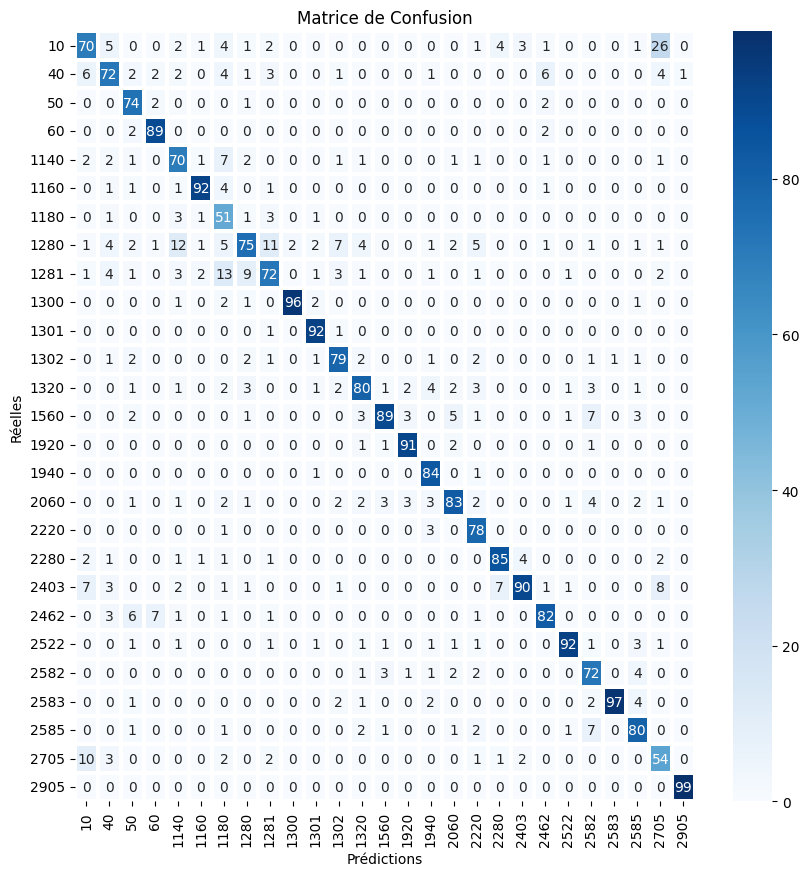

In [3]:

y_pred_out = y_pred_test.logits
y_pred = np.argmax(y_pred_out, axis=-1)

trainer.evaluateTestResults(y_test,y_pred)

In [1]:
from RktnChallenge.RktnModel import ModelTrainer



import tensorflow as tf


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import CamembertTokenizer, TFCamembertForSequenceClassification
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import AdamW

import ast

trainer = ModelTrainer("data_tr_lemm.csv","")
nb_epochs = 10
num_categories = 27
max_features = 250
checkpoint_path = "cbert_best_desi"

def convert_and_join(str_list):
    try:
        # Convertir la chaîne en liste
        real_list = ast.literal_eval(str_list)
        # Joindre la liste pour former une chaîne
        return " ".join(real_list)
    except (ValueError, SyntaxError):
        return ""



sentences =  trainer.data["designation_tkn"].apply(convert_and_join).values.tolist()

from transformers import CamembertConfig, TFCamembertModel

config = CamembertConfig.from_pretrained(checkpoint_path)
config.num_labels = 27
tokenizer = CamembertTokenizer.from_pretrained(checkpoint_path)
model = TFCamembertModel.from_pretrained(checkpoint_path, config=config)


for layer in model.layers:
    layer.trainable = False


2023-09-12 15:03:09.246920: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-12 15:03:09.270645: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9511] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-09-12 15:03:09.270665: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-09-12 15:03:09.270677: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-12 15:03:09.275842: I tensorflow/core/platform/cpu_feature_guar

In [2]:
from tqdm import tqdm

def sentence_to_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors="tf", truncation=True,  max_length=max_features)
    outputs = model(inputs.input_ids)
    embeddings = outputs.last_hidden_state
    
    embeddings = tf.reduce_mean(embeddings, axis=1)    
    return embeddings.numpy()

df = pd.read_csv("data_tr_lemm.csv")

# embeddings pour chaque texte
df['embeddings_desi'] = [sentence_to_embedding(text) for text in tqdm(sentences)]

df.to_csv("embeddings.csv", index=False)


100%|██████████| 84916/84916 [2:45:42<00:00,  8.54it/s]  
